In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator
from numpy.linalg import cond
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
from numpy.linalg import svd
import seaborn as sns
sns.set(palette='Set2')

from sklearn.base import BaseEstimator

В данном проекте я буду сравнивать свойства линейных регрессионных моделей: обычной, Lasso, Ridge, Elastic Net.  

Используем данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018`</a>, взятые с DASL.  

Краткое описание датасета:

Индекс стоимости жизни (Cost of Living Index) является относительным показателем цен на потребительские товары, включая продукты питания, рестораны, транспорт и коммунальные услуги (исключая аренду и ипотеку).  Если индекс стоимости жизни в городе равен 120, это означает, что, по оценкам Numbeo, он на 20% дороже Нью-Йорка.

Индекс арендной платы (Rent Index) - это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком.

Индекс стоимости жизни плюс арендная плата (Cost of Living Plus Rent Index) - это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

Индекс ресторанов (Restaurant Price Index) - это сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорком.

Местная покупательная способность (Local Purchasing Power Index) показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если покупательная способность равна 40, это означает, что жители этого города со средней зарплатой могут позволить себе купить в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой.

Индекс продуктов (Groceries Index) - это оценка цен на продукты в городе по сравнению с Нью-Йорком.

**Задача:** построение предсказания `Groceries Index` по известным значениям остальных параметров.

In [2]:
data = pd.read_csv('cost-of-living-2018.txt', sep='\t')
data = data[[
    'Cost of Living Index',
    'Rent Index',
    'Cost of Living Plus Rent Index',
    'Restaurant Price Index',
    'Local Purchasing Power Index',
    'Groceries Index'
]]

data.head()

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Restaurant Price Index,Local Purchasing Power Index,Groceries Index
0,145.43,110.87,128.76,158.75,112.26,143.47
1,141.25,66.14,105.03,135.76,142.70,149.86
2,134.83,71.70,104.38,129.74,130.96,138.98
3,130.68,49.68,91.61,127.22,139.01,127.54
4,128.03,43.57,87.30,119.48,112.71,132.70


In [3]:
X = data.drop('Groceries Index', axis=1)
y = data['Groceries Index']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Методы с регуляризацией требуют страндартизации признаков, чтобы при работе с коэффициентами избавится от размерности и сравнять масштабы (без стандартизации признаки с большими значениями могут доминировать в модели).

In [5]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
X_scaled = np.concatenate((X_train_scaled, X_test_scaled), axis=0)

 Исследуем зависимость значений коэффициентов от параметра регуляризации `alpha` для Ridge, Lasso, Elastic регрессий. Для Elastic также исследуйем зависимость от параметра `l1_ratio`.

In [6]:
def draw_track(model, X, y, log_min, log_max, num, title='', figsize=(12, 6)):
    """Данная функция строит график зависимости значений
    коэффициентов модели от параметра регуляризации.

    :param model: модель
    :param X: регрессоры
    :param y: отклик
    :param log_min: десятичный логарифм
        минимального значения коэффициента регуляризации
    :param log_max: десятичный логарифм
        максимального значения коэффициента регуляризации
    :param num: количество элементов в сетке для коэффициента регуляризации
    :param title: заголовок графика
    :param figsize: размер полотна
    """

    alphas = np.logspace(log_min, log_max, num)
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            # равномерно распределим alpha по обоим коэффициентам
            a *= 3/2
            model.set_params(alpha=a)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
#     ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1

    ax.set_xscale('log')
#     ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()
def draw_l1_ratio(model, X, y, log_min, log_max, num, title='', figsize=(12, 6)):
    l1_ratios = np.linspace(log_min, log_max, num)
    coefs = []
    for a in l1_ratios:
        model.set_params(l1_ratio=a)
        model.fit(X, y)
        coefs.append(model.coef_)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(l1_ratios, coef, linewidth=2, label=label)
        ind += 1
    plt.xlabel('l1_ratio', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

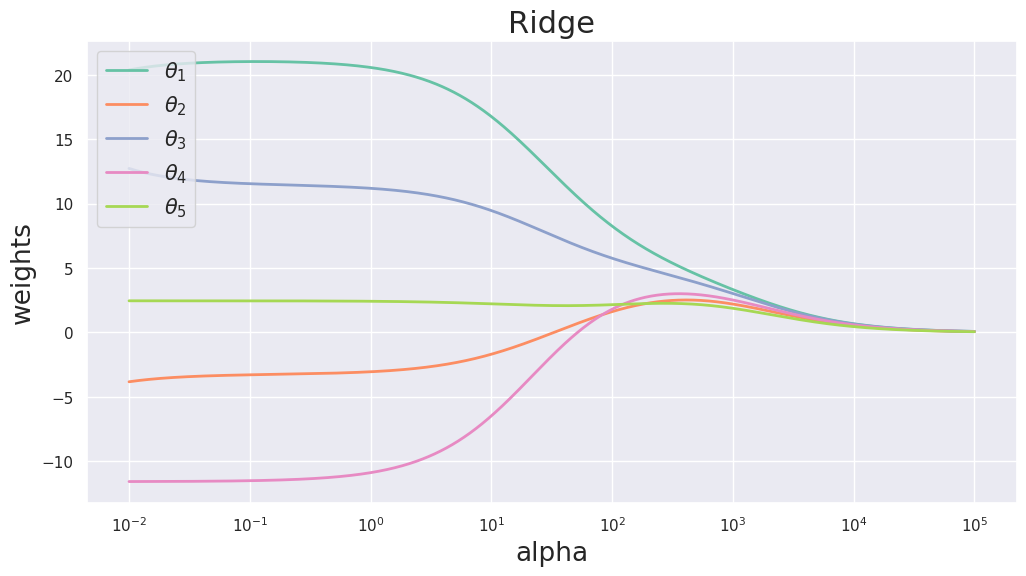

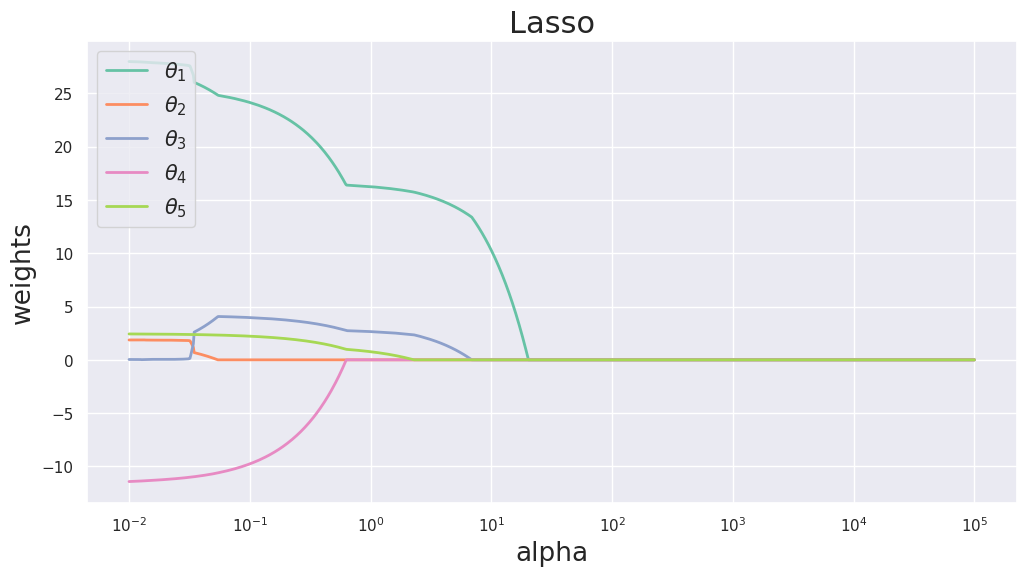

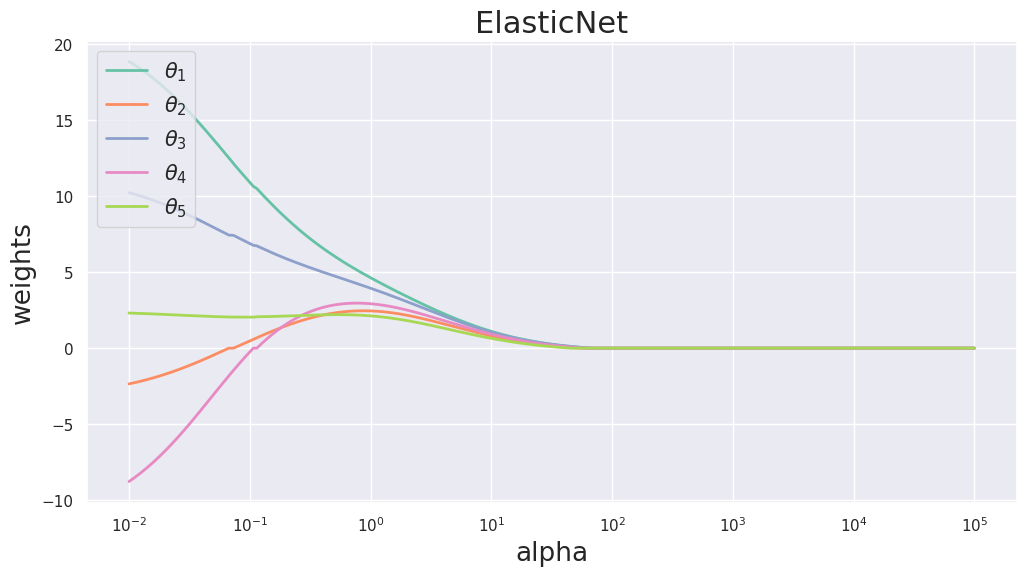

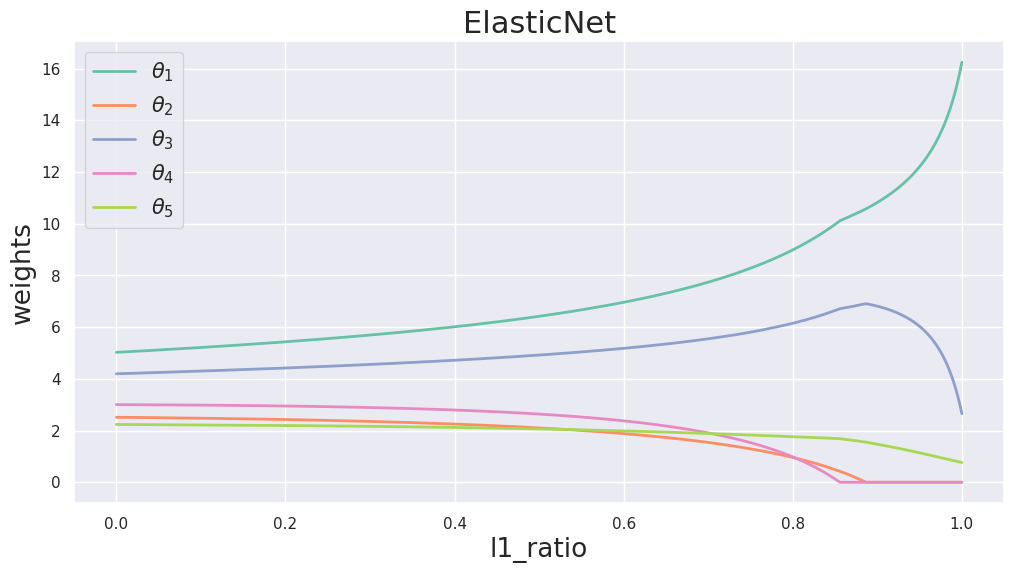

In [7]:
draw_track(Ridge(fit_intercept=True), X_train_scaled, y_train, -2, 5, 1000,
           title='Ridge')
draw_track(Lasso(fit_intercept=True), X_train_scaled, y_train, -2, 5, 1000,
           title='Lasso')
draw_track(ElasticNet(fit_intercept=True, l1_ratio=0.2), X_train_scaled, y_train, -2, 5, 1000,
           title='ElasticNet')
draw_l1_ratio(ElasticNet(fit_intercept=True, max_iter=1000), X_train_scaled, y_train, 0, 1, 1000, title='ElasticNet')

Для всех регрессий оптимальное значение $\alpha$ лежит в промежутке $[10^{-1}, 10]$, при больших значениях зануляются веса, а при меньших - регуляризация слишком слабая.

Расчитаем индекс обусловленности для МНК-решения. Построим график зависимости индекса обусловленности от параметра регуляризации для Ridge-регрессии.

In [8]:
cond_mnk = cond(X_train)
print(f"Индекс обусловленности для МНК-решения: {cond_mnk}")

Индекс обусловленности для МНК-решения: 51094.47308914123


Значение индекса обусловленности очень большое, что говорит о сильной мультиколлинеарности данных.

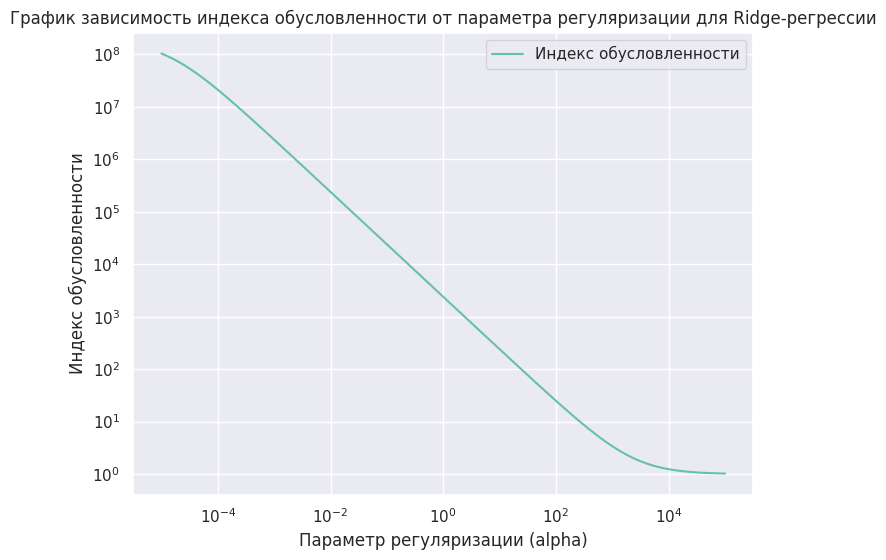

In [9]:
# Диапазон значений регуляризации для Ridge
alphas = np.logspace(-5, 5, 100)

# Вычисление индекса обусловленности для каждого значения альфы
cond_numbers = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)
    # Вычисление индекса обусловленности по матрице признаков после регуляризации
    cond_number = cond(X_scaled.T @ X_scaled + alpha * np.eye(X_scaled.shape[1]))
    cond_numbers.append(cond_number)

# Построение графика зависимости индекса обусловленности от параметра регуляризации
plt.figure(figsize=(8, 6))
plt.plot(alphas, cond_numbers, label="Индекс обусловленности")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Параметр регуляризации (alpha)')
plt.ylabel('Индекс обусловленности')
plt.title('График зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии')
plt.grid(True)
plt.legend()
plt.show()


 На обучающей выборке с помощью поиска по сетке определим наилучшие параметры для Ridge, Lasso, Elastic моделей по MSE.

In [10]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet())
])

# Параметры для поиска по сетке
param_grid_ridge = {
    'model__alpha': np.logspace(-4, 4, 10)
}

param_grid_lasso = {
    'model__alpha': np.logspace(-4, 4, 10)
}

param_grid_elastic = {
    'model__alpha': np.logspace(-4, 4, 10),
    'model__l1_ratio': np.linspace(0, 1, 10)
}

# Настройка поиска по сетке для каждой модели
ridge_search = GridSearchCV(ridge_pipeline, param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
lasso_search = GridSearchCV(lasso_pipeline, param_grid_lasso, scoring='neg_mean_squared_error', cv=5)
elastic_search = GridSearchCV(elastic_pipeline, param_grid_elastic, scoring='neg_mean_squared_error', cv=5)

ridge_search.fit(X_train, y_train)
lasso_search.fit(X_train, y_train)
elastic_search.fit(X_train, y_train)

# Вывод параметров с точностью до 5 знаков после запятой
def print_best_params(search, model_name):
    print(f"Лучшие параметры для {model_name}:")
    for key, value in search.best_params_.items():
        print(f"  {key}: {value:.5f}")
    print(f"Лучшее значение MSE для {model_name}: {-search.best_score_:.5f}")

print_best_params(ridge_search, "Ridge")
print_best_params(lasso_search, "Lasso")
print_best_params(elastic_search, "ElasticNet")


Лучшие параметры для Ridge:
  model__alpha: 0.35938
Лучшее значение MSE для Ridge: 34.92605
Лучшие параметры для Lasso:
  model__alpha: 0.00599
Лучшее значение MSE для Lasso: 34.94539
Лучшие параметры для ElasticNet:
  model__alpha: 0.00599
  model__l1_ratio: 0.77778
Лучшее значение MSE для ElasticNet: 34.92258


На тестовой части данных сравним качество моделей с оптимальными параметрами.

In [11]:
# Оценка моделей на тестовой выборке
ridge_best_model = ridge_search.best_estimator_
lasso_best_model = lasso_search.best_estimator_
elastic_best_model = elastic_search.best_estimator_

y_pred_ridge = ridge_best_model.predict(X_test)
y_pred_lasso = lasso_best_model.predict(X_test)
y_pred_elastic = elastic_best_model.predict(X_test)

print(f"MSE на тестовой выборке (Ridge): {mean_squared_error(y_test, y_pred_ridge):.5f}")
print(f"MSE на тестовой выборке (Lasso): {mean_squared_error(y_test, y_pred_lasso):.5f}")
print(f"MSE на тестовой выборке (ElasticNet): {mean_squared_error(y_test, y_pred_elastic):.5f}")

MSE на тестовой выборке (Ridge): 33.57751
MSE на тестовой выборке (Lasso): 33.48659
MSE на тестовой выборке (ElasticNet): 33.65107


Все используемые модели регрессии дали хороший результат, что позволяет успешно применять их для данных из нашей задачи.

**Вывод:** В данном проекте были исследовано поведение Ridge, Lasso и Elastic регрессии на исходных данных. Все регрессии оказались эффективными при оптимальном подборе гиперпараметров, а также помогли избежать проблемы мультиколлинеарности.